In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"
from jax.config import config
# This slows down the computation by ~ x8. But single precision leads to discretization effects.
config.update("jax_enable_x64", True)  
import jax.numpy as jnp
from jax import jit, vmap, random

import sys
sys.path.append("..")
from hyperion.propagate import (
   
    make_initialize_direction_laser,
    initialize_direction_isotropic,
    make_monochromatic_initializer,
    make_photon_trajectory_fun,
    make_step_function,
    make_multi_photon_sphere_intersection_func,
    make_photon_sphere_intersection_func,
    make_cherenkov_spectral_sampling_func,
    
    make_loop_until_isec_or_maxtime,
    make_loop_for_n_steps,
    make_fixed_pos_time_initializer,
    collect_hits
)
from hyperion.medium import (
     cascadia_ref_index_func,
     mixed_hg_rayleigh_antares,
     sca_len_func_antares,
     henyey_greenstein_scattering_angle,
)
from hyperion.constants import Constants
from hyperion.utils import calculate_min_number_steps
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns
from scipy.interpolate import UnivariateSpline
import scipy.stats
import pandas as pd

In [3]:
# We want to calculate intersections with a sphere
dists = np.asarray([30, 50, 60, 70, 80, 100.]) # m
det_radius = np.full_like(dists, 0.21)

phis = np.linspace(0, 2*np.pi, len(dists), endpoint=False)
x = dists*np.cos(phis)
y = dists*np.sin(phis)
z = np.zeros_like(phis)
det_positions = np.vstack([x, y, z]).T

intersection_f = make_multi_photon_sphere_intersection_func(det_positions, det_radius)

scattering_function = mixed_hg_rayleigh_antares
#scattering_function = lambda k: henyey_greenstein_scattering_angle(k, 0.97)
scattering_length_function = lambda wl: 30 # m
ref_index_func = cascadia_ref_index_func

# Isotropic photon emission
emission_dir_init = initialize_direction_isotropic
wavelength_init = make_monochromatic_initializer(400)

photon_init = make_fixed_pos_time_initializer(
    jnp.asarray([0., 0., 0.]),
    0., 
    emission_dir_init,
    wavelength_init)


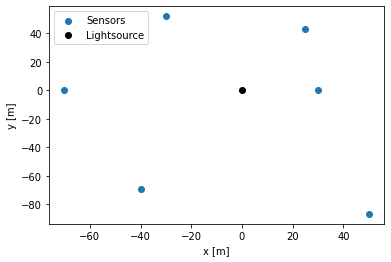

In [4]:
plt.scatter(det_positions[:, 0], det_positions[:, 1], label="Sensors")
plt.plot(0, 0, "ok", label="Lightsource")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend()
plt.savefig("../figures/att_len_fit_test_geo.png", dpi=150)

In [5]:
sca_lens = np.logspace(np.log10(20), np.log10(200), 7)
all_data = []
for sca_len in sca_lens:
    # Use the ANTARES wavelength dependent scattering length

    initialize_direction_isotropic
    step_fun = make_step_function(
        intersection_f=intersection_f,
        scattering_function=scattering_function,
        scattering_length_function=lambda wl: sca_len,
        ref_index_func=ref_index_func,
    )

    loop_func = make_loop_for_n_steps(25)
    # make a trajectory function
    trajec_fun = make_photon_trajectory_fun(
        step_fun,
        photon_init,
        loop_func=loop_func,
    )

    # Create a compiled and vectorized trajectory function
    trajec_fun_v = jit(vmap(trajec_fun, in_axes=[0]))
    data = collect_hits(trajec_fun_v, 5E6, 20)
    all_data.append(data)

KeyboardInterrupt: 

In [ ]:
c_medium = Constants.BaseConstants.c_vac / ref_index_func(400) * 1E-9
def make_df_for_abs(all_data, abs_len):
    nph_per_dist = []
    nph_per_dist_direct = []
    for i in range(len(all_data)):

        match_modules = all_data[i][-3][:, np.newaxis] - det_positions 
        ph_mod_ix = jnp.argmin(jnp.linalg.norm(match_modules, axis=-1), axis=1)
        
        for j in range(det_positions.shape[0]):

            tgeo = dists[j]/c_medium
            bins = np.linspace(tgeo, tgeo+200, 20)

            mask = ph_mod_ix == j
            times = all_data[i][0][mask]
            weights = np.exp(-all_data[i][0][mask] * c_medium / abs_len)

            direct_mask = (times - tgeo) < 2

            nph_per_dist.append({"sca_len": sca_lens[i], "dist": dists[j], "nph_det": weights.sum(), "nph_em": (all_data[i][-2] * 5E6)})
            nph_per_dist_direct.append({"sca_len": sca_lens[i], "dist": dists[j], "nph_det": weights[direct_mask].sum(), "nph_em": (all_data[i][-2] * 5E6)})

    nph_per_dist = pd.DataFrame(nph_per_dist)
    nph_per_dist_direct = pd.DataFrame(nph_per_dist_direct)

    def calc_quantities(df):
        df["att_len"] = 1 / (1/df["sca_len"] + 1/abs_len)
        df["nph_exp"] = (
            df["nph_em"] *
            (0.21**2)/ (df["dist"]**2) * 
            np.exp(-df["dist"]/df["att_len"])
        )
        sca_eff = df["sca_len"] / (1-0.97)
        lambda_p = np.sqrt(df["att_len"] * sca_eff / 3)
        zeta = np.exp(-sca_eff/df["att_len"])
        lambda_c = sca_eff / (3 * zeta)

        df["nph_exp_better"] = (
            df["nph_em"] *
            (0.21**2) *
            np.exp(-df["dist"]/lambda_p) 
            * 1/ (lambda_c * df["dist"] * np.tanh(df["dist"] / lambda_c))
           
        )
        return df

    return calc_quantities(nph_per_dist), calc_quantities(nph_per_dist_direct)


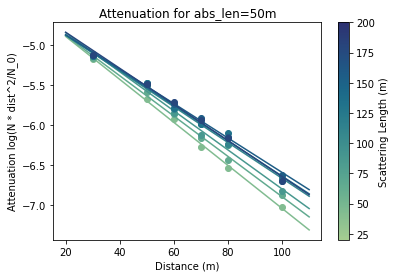

In [ ]:
nph_per_dist, nph_per_dist_direct = make_df_for_abs(all_data, 50)
plt.title("Attenuation for abs_len=50m")
colors = sns.color_palette("crest", len(sca_lens))
for (groupn, grp), color in zip(nph_per_dist_direct.groupby("sca_len"), colors):
    x = np.asarray(grp.dist)
    y = np.asarray(np.log(grp["nph_det"] * grp["dist"]**2/ grp["nph_em"]))

    fitres = np.polyfit(x, y, 1)

    plt.plot(x, y, "o", color=color)
    xs = np.linspace(20, 110, 100)
    plt.plot(xs, np.poly1d(fitres)(xs), color=color)


plt.xlabel("Distance (m)")
plt.ylabel("Attenuation log(N * dist^2/N_0)")
cmap = sns.color_palette("crest", len(sca_lens), as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=sca_lens[0], vmax=sca_lens[-1]))
cbar = plt.colorbar(sm)
cbar.set_label("Scattering Length (m)")

plt.savefig("../figures/att_len_fit_test_attenuation.png", dpi=150)

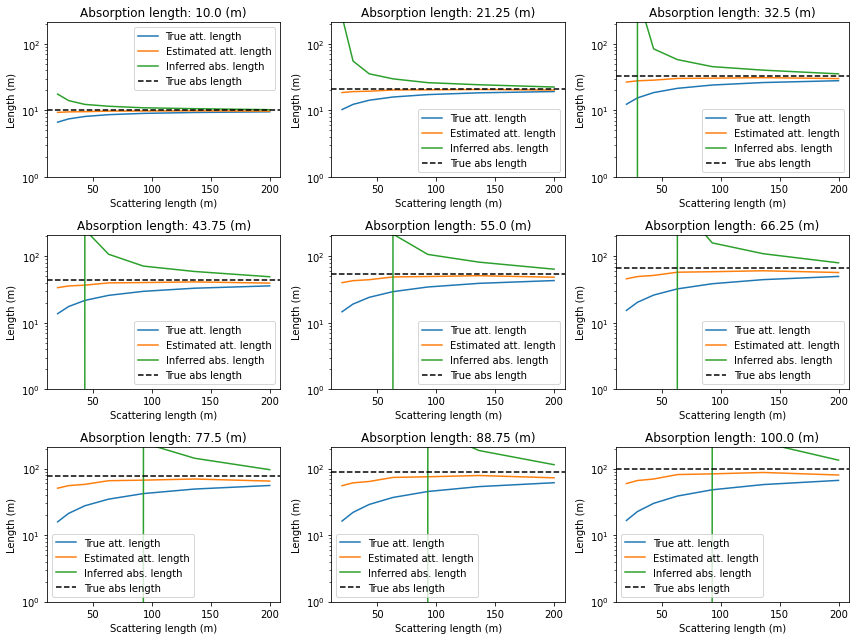

In [10]:
abs_lengths = np.linspace(10, 100, 9)

fig, axs = plt.subplots(3, 3, figsize=(3*4, 3*3))

for abs_len, ax in zip(abs_lengths, axs.ravel()):

    nph_per_dist, nph_per_dist_direct = make_df_for_abs(all_data, abs_len)

    def fit(grp):
        x = np.asarray(grp.dist)
        y = np.asarray(np.log(grp["nph_det"] * grp["dist"]**2/ grp["nph_em"]))
        return -1/np.polyfit(x, y, 1)[0]

    att_len_est = nph_per_dist_direct.groupby("sca_len").apply(fit)
    
    ax.plot(sca_lens, 1/(1/sca_lens + 1/abs_len), label="True att. length")
    ax.plot(att_len_est.index, att_len_est.values, label="Estimated att. length")
    ax.plot(att_len_est.index, 1/(1/att_len_est.values - 1/sca_lens), label="Inferred abs. length")
    ax.axhline(abs_len, color="k", ls="--", label="True abs length")
    ax.legend()
    ax.set_ylim(1, 210)
    ax.set_yscale("log")
    ax.set_xlabel("Scattering length (m)")
    ax.set_ylabel("Length (m)")
    ax.set_title(f"Absorption length: {abs_len} (m)")
plt.tight_layout()
plt.savefig("../figures/att_len_fit_test_analysis.png", dpi=150)